In [1]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from cmass_modules import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append('/n/des/lee.5922/programs/chomp')
import correlation
import cosmology
import halo
import hod
import kernel
import mass_function

In [8]:
from scipy.integrate import simps  

In [9]:
def integrate( array, x=None, dx = None):
    from scipy.integrate import simps  
    return simps( array, x = x, dx=dx )

def produce_massbin(mass_min, mass_max, nM = 200, lnM = False):
    
    import numpy
    dln_mass = (numpy.log(mass_max) - numpy.log(mass_min))/nM
    ln_mass_max = numpy.log(mass_max) + dln_mass
    ln_mass_min = numpy.log(mass_min) - dln_mass

    ln_mass_array = numpy.arange(
        ln_mass_min, ln_mass_max + dln_mass, dln_mass)
    
    if lnM : return ln_mass_array, dln_mass
    else : return np.exp(ln_mass_array), dln_mass

In [10]:
def CMASS_HOD(mass, nth = 3) : 
    
    hod_dict = {"log_M_min": 12.99139,
            "sigma":     0.3076970,
            "log_M_0":  13.19778,
            "log_M_1p": 14.07659,
            "alpha":      0.8242392}
    
    cmass_hod = hod.HODZheng(hod_dict)
    result = np.sum([cmass_hod.first_moment(mass), cmass_hod.second_moment(mass),
                cmass_hod.nth_moment(mass,3, None)])
    if nth == 1 : result = cmass_hod.first_moment(mass)
    elif nth == 2 : result = np.sum([cmass_hod.first_moment(mass), cmass_hod.second_moment(mass)])
    else : result = np.sum([cmass_hod.first_moment(mass), cmass_hod.second_moment(mass),
                cmass_hod.nth_moment(mass,3, None)])
        
    return result

In [30]:


def HOD(M, Mcut = 1e11):
    p = np.zeros(M.size)
    p[M>Mcut] = 1
    return p


def halo_mass_tinker(M):
    
    from colossus.cosmology.cosmology import setCosmology
    cosmo = setCosmology('planck15')

    from colossus.lss import mass_function
    z = 0.0
    mfunc_so = mass_function.massFunction(M, z, q_in = 'M', mdef = 'vir', model = 'tinker08')

    return mfunc_so

def bias_halo_tinker(M, z = 0):
    from systematics_module.contCorrection import haloBiasTinker10
    nu, HaloBias = haloBiasTinker10(M, z = z)  
    return HaloBias



In [15]:
def num_gal(M_halobin, st_mass, dlnM= 1):
    
    #dlnM = np.log10(M_halobin[1]*2./M_halobin[0])
    #dndm = np.array([halo_mass(m, st_mass) for m in M_halobin])
    hod =  np.array([CMASS_HOD(m) for m in M_halobin])
    
    dndm = st_mass.dndm(M_halobin)
    ng = integrate( dndm * hod, x= M_halobin, dx = None )
    return ng

def bias_gal(M_halobin, st_mass, dlnM = 1):
    
    dndm = st_mass.dndm(M_halobin)
    bh = st_mass.bias_m(M_halobin)
    #dndm = np.array([halo_mass(m, st_mass) for m in M_halobin])
    hod =  np.array([CMASS_HOD(m) for m in M_halobin])
    #bh = np.array([bias_halo(m, st_mass) for m in M_halobin])
    array = dndm * hod * bh
    ng = num_gal(M_halobin, st_mass)
    
    #array = halo_mass(M_halobin) * bias_halo(M_halobin) * CMASS_HOD(M_halobin)
    #dlnM = np.log10(M_halobin[1]*2./M_halobin[0])
    bg = 1./ng * integrate( array, x= M_halobin, dx = None)
    return bg

def dbg_dng(Mmin, st_mass):  
    mass_max = 1.0e16
    mass_min = 1.0e9
    #M_halobin = np.logspace(9, 16, 1000, base=10.)
    M_halobin, dlnM = produce_massbin(mass_min, mass_max)
    
    bh = st_mass.bias_m(Mmin)
    ng = num_gal(M_halobin, st_mass, dlnM = None)
    bg = bias_gal(M_halobin, st_mass, dlnM = None)
    return 1./ng * ( -1.* bg + bh)

In [15]:
#M_halobin = np.logspace(9, 16, 1000, base=10.)
M_halobin, dlnM = produce_massbin(mass_min, mass_max, nM = 100)
ng = num_gal(M_halobin, st_mass, dlnM = dlnM)
bg = bias_gal(M_halobin, st_mass, dlnM = dlnM)

NameError: name 'mass_min' is not defined

In [493]:
ng, bg, dlnM

(0.0013142146808001228, 2.2338741116557106, 0.16118095650958325)

In [433]:
dbg_dnglist = [dbg_dng(M, st_mass) for M in M_halobin]

In [1342]:
Mmin_cmass = 10**(12.99139)
dbg_dng_Mmin = dbg_dng(Mmin_cmass, st_mass)
b_difference = dbg_dng_Mmin * ng * (N_cmass - N_dmass * A_cmass/A_dmass)*1./N_cmass
print 'db_dn', dbg_dng_Mmin
print 'b_diff', b_difference/b_cmass * 100, '%'

print 'A_cmass', A_cmass, ' A_dmass', A_dmass
print 'N_cmass', N_cmass, ' N_dmass', N_dmass
#sigma_n = poisson_sigman(cmass_ngc)
#sigma_b = dbg_dng_Mmin * sigma_n
#sigma_n_percentage = poisson_sigman_dmass_percentage()
#sigma_b_cosmic = dbg_dng_Mmin * poisson_sigman_dmass()
#print sigma_b, sigma_b_cosmic

db_dn -1062.590140127243
b_diff 2.2357020521617015 %
A_cmass 6689.347390836286  A_dmass 1260.9130947509416
N_cmass 566850  N_dmass 110270


In [ ]:
N_cmass = cmass_ngc.size
db_dn =  b_cmass * (1.-1*./brel_bestfit) * 1./0.15/N_cmass

sigma_n = poisson_sigman(dmass_spt)
sigma_b = db_dn * poisson_sigman_dmass()

print sigma_b

(12, 16)

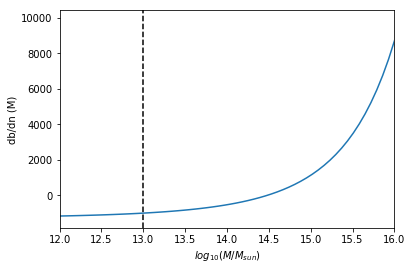

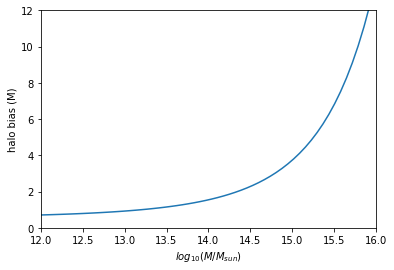

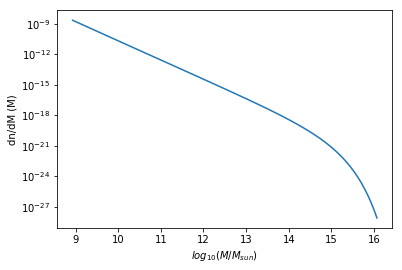

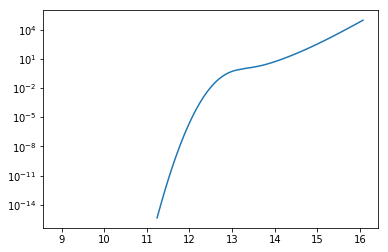

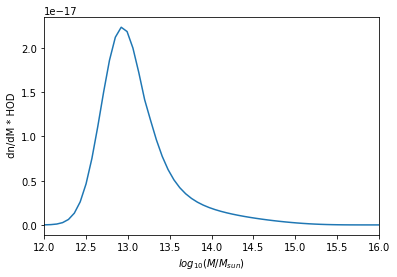

In [495]:
fig, ax = plt.subplots()
ax.plot(np.log10(M_halobin), dbg_dnglist)
ax.axvline(x = np.log10(Mmin_cmass), color = 'k', linestyle = '--')
ax.set_xlabel(r'$log_{10} (M/M_{sun})$')
ax.set_ylabel('db/dn (M)')
ax.set_xlim(12,16)
#ax.set_yscale('log')

#bias_halo_list = [bias_halo(m) for m in M_halobin]
bias_tinker =[ bias_halo_tinker(m, z = 0) for m in M_halobin]
fig, ax = plt.subplots()
ax.plot(np.log10(M_halobin), st_mass.bias_m(M_halobin))
#ax.plot(np.log10(M_halobin), bias_tinker)
ax.set_xlabel(r'$log_{10} (M/M_{sun})$')
ax.set_ylabel('halo bias (M)')
ax.set_xlim(12,16)
#ax.set_yscale('log')
ax.set_ylim(0, 12)

#hm_tinker = [halo_mass_tinker(m) for m in M_halobin]
fig, ax = plt.subplots()
ax.plot(np.log10(M_halobin), st_mass.dndm(M_halobin))
#ax.plot(np.log10(M_halobin), hm_tinker)
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10} (M/M_{sun})$')
ax.set_ylabel('dn/dM (M)')

fig, ax = plt.subplots()
cmass_hod =  np.array([CMASS_HOD(m) for m in M_halobin])
ax.semilogy(np.log10(M_halobin), cmass_hod)

fig, ax = plt.subplots()
p_max = (st_mass.dndm(M_halobin) * cmass_hod).max()
ax.plot(np.log10(M_halobin), st_mass.dndm(M_halobin) * cmass_hod )
ax.set_xlabel(r'$log_{10} (M/M_{sun})$')
ax.set_ylabel(' dn/dM * HOD')
ax.set_xlim(12,16)

In [2]:
sys.path.append('/n/des/lee.5922/programs/chomp')
import correlation
import cosmology
import halo
import hod
import kernel
import mass_function

In [7]:
cosmo_dict = {
    "omega_m0": 0.3 - 4.15e-5/0.7**2,
    "omega_b0": 0.046,
    "omega_l0": 0.7,
    "omega_r0": 4.15e-5/0.7**2,
    "cmb_temp": 2.726,
    "h"       : 0.7,
    "sigma_8" : 0.800,
    "n_scalar": 0.960,
    "w0"      : -1.0,
    "wa"      : 0.0
    }
halo_dict = {
    "stq": 0.3,
    "st_little_a": 0.707,
    "c0": 9.,
    "beta": -0.13,
    "alpha": -1,
    "delta_v": -1
    }

cosmo_single = cosmology.SingleEpoch(redshift=0.0, cosmo_dict=cosmo_dict,
                                 with_bao=False)
#Sheth& Tormen mass function
st_mass = mass_function.MassFunction(redshift=0.0, cosmo_single_epoch=cosmo_single,
                                  halo_dict=halo_dict)
#st_mass.write('massftn.txt')

In [8]:
# BOSS CMASS
#{"Mmin" : 12.99139,
#  "M1" : 14.07659,
#  "alpha" : 0.8242392, 
#  "Mcut" : 13.19778,
#  "sigma_logm" : 0.3076970}
    
hod_dict = {"log_M_min": 12.99139,
            "sigma":     0.3076970,
            "log_M_0":  13.19778,
            "log_M_1p": 14.07659,
            "alpha":      0.8242392}

cmass_hod = hod.HODZheng(hod_dict)

"""
HOD object describing the model from Zheng2007. Input is a dictionary
of variable names and values. Names for these variables are listed below.
Attributes:
    M_min: Minimum mass for a halo to to contain a central galaxy
    sigma: with of central the central galaxy turn on
    M_0: minimum mass for a halo to contain satellite galaxies. Note: 
        Wake et al. 2011 and Zehavi et al. 2011 show show that M_0~M_min
    M_1p: Mass differential at which a halo contains one satellite (M-M_0).
    alpha: slope of the satellite number counts. Note: This is motivated to
        be 1. (see references above)
"""
    
halo_model = halo.Halo(redshift=0.0, input_hod=cmass_hod,
                       cosmo_single_epoch=cosmo_single)

In [9]:
mass_max = 1.0e16
mass_min = 1.0e9

import numpy
dln_mass = (numpy.log(mass_max) - numpy.log(mass_min))/200
ln_mass_max = numpy.log(mass_max) + dln_mass
ln_mass_min = numpy.log(mass_min) - dln_mass

ln_mass_array = numpy.arange(
    ln_mass_min, ln_mass_max + dln_mass, dln_mass)

output_filename = 'hod_test.txt'
f = open(output_filename, "w")
for ln_mass in ln_mass_array:
    mass = numpy.exp(ln_mass)
    f.write("%1.10f %1.10f %1.10f %1.10f\n" % (
                mass, cmass_hod.first_moment(mass), cmass_hod.second_moment(mass),
                cmass_hod.nth_moment(mass,3, None)))
    

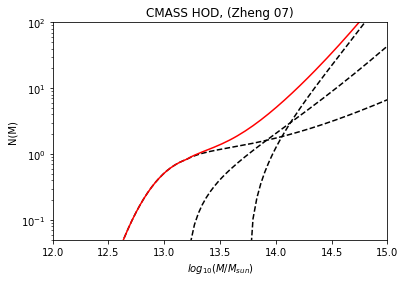

In [11]:
fig, ax = plt.subplots()

massbin, fst, snd, nth = np.genfromtxt('hod_test.txt', unpack=True)
logmass= np.log10(massbin)
ax.plot(logmass, fst, 'k--')
ax.plot(logmass, snd, 'k--')
ax.plot(logmass, nth, 'k--')
ax.plot(logmass, fst + snd + nth , 'r-')
ax.set_yscale('log')
ax.set_ylim(0.05, 100)
ax.set_xlim(12, 15)
ax.set_xlabel(r'$log_{10} (M/M_{sun})$')
ax.set_ylabel('N(M)')
ax.set_title('CMASS HOD, (Zheng 07)')

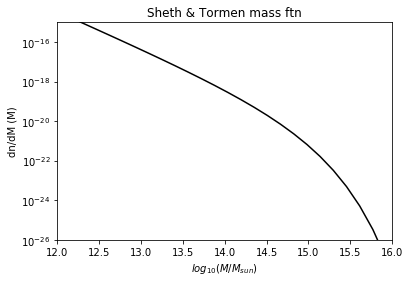

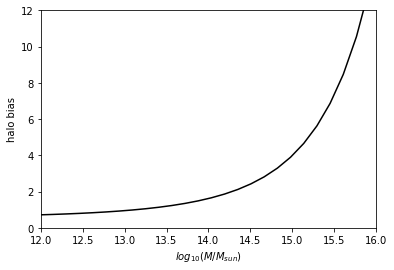

In [13]:

mass, nu, fnu, bnu = np.genfromtxt('../massftn.txt', unpack=True)
bm = st_mass.bias_m(mass)
st_dndm = st_mass.dndm(mass)
fig, ax = plt.subplots()
#ax.plot(np.log10(mass), bm)
ax.plot(np.log10(mass), st_dndm, 'k-')
#ax.axvline(x = np.log10(Mmin_cmass), color = 'grey', linestyle = '--')
ax.set_xlim(12, 16)
ax.set_ylim(1e-26,1e-15)
ax.set_yscale('log')
ax.set_xlabel(r'$log_{10} (M/M_{sun})$')
ax.set_ylabel('dn/dM (M)')
ax.set_title('Sheth & Tormen mass ftn')

fig, ax = plt.subplots()
ax.plot(np.log10(mass), bm, 'k-')
#ax.axvline(x = np.log10(Mmin_cmass), color = 'grey', linestyle = '--')
#ax.plot(np.log10(mass), st_dndm)
#ax.set_yscale('log')
ax.set_ylim(0,12)
ax.set_xlim(12, 16)
ax.set_xlabel(r'$log_{10} (M/M_{sun})$')
ax.set_ylabel('halo bias')
ax.set_title('')

JK test 

In [580]:


import os, sys
from suchyta_utils import jk

print 'JK sampling'
sys.stdout.flush()

jkfile = './jkregion.txt'

raTag, decTag = 'RA', 'DEC'
jk.GenerateJKRegions( cmass_ngc[raTag], cmass_ngc[decTag], 10, jkfile )

#jktest = jk.SphericalJK( target = _constructing_input_file, jkargs=[ data, rand ], 
#                        jkargsby=[[raTag, decTag],[raTag, decTag]], regions = jkfile, 
#                        nojkkwargs = {'suffix':suffix})
#jktest.DoJK( regions = jkfile, mpi=mpi )
#jkresults = jktest.GetResults(jk=True, full = False)
#os.remove(jkfile)

JK sampling
X (1505, 2)  centers (10, 2)  tol=1e-05  maxiter=200
26 iterations  cluster sizes: [170 144 125 144 128 156 170 166 141 161]
X (566850, 2)  centers (10, 2)  tol=1e-05  maxiter=200
33 iterations  cluster sizes: [70069 49040 48029 56507 58930 60067 59040 54149 56409 54610]


In [581]:
cat jkregion.txt

1.866502672397804758e+02 1.247229610339111261e+01
2.104979261479554395e+02 2.845615935458574342e+01
2.323211391834970527e+02 4.582277532667336573e+01
2.177304811392343993e+02 6.611718555890205629e+00
2.432789534717561537e+02 2.251301342093752567e+01
1.318641030775989407e+02 1.347303091213154325e+01
1.591686123486870770e+02 3.472169161719406816e+01
1.281294251716646215e+02 4.076011461597185104e+01
1.884315985581222037e+02 4.479038936876109034e+01
1.590833233514738083e+02 9.151194831731338297e+00


In [656]:
def GenerateRegions(jarrs, jras, jdecs, jfile, njack, jtype):

    import kmeans_radec
    
    if jtype=='generate':
        rdi = np.zeros( (len(jarrs),2) )
        rdi[:,0] = jras# jarrs[gindex][jras[gindex]]
        rdi[:,1] = jdecs #jarrs[gindex][jdecs[gindex]]

        if jfile is None:
            jfile = 'JK-{0}.txt'.format(njack)
        km = kmeans_radec.kmeans_sample(rdi, njack, maxiter=200, tol=1.0e-5)

        if not km.converged:
            raise RuntimeError("k means did not converge")
        np.savetxt(jfile, km.centers)

    elif jtype=='read':
        centers = np.loadtxt(jfile)
        km = kmeans_radec.KMeans(centers)
        njack = len(centers)

    return [km, jfile]


def AssignIndex(jarrs, jras, jdecs, km):
    
    ind = []
    for i in range(len(jarrs)):
        rdi = np.zeros( (len(jarrs[i]),2) )
        rdi[:,0] = jras[i]
        rdi[:,1] = jdecs[i]
        index = km.find_nearest(rdi)
        ind.append(index[0])
    return np.array(ind)

def construct_jk_catalog( cat, rand, njack = 10, root='./', suffix = '' ):
    
    #jarrs = cat
    #jras = cat['RA']
    #jdecs = cat['DEC']
    jfile = 'jkregion.txt'
    jtype = 'generate'
    
    km, jfile = GenerateRegions(cat, cat['RA'], cat['DEC'], jfile, njack, jtype)
    ind = AssignIndex(cat, cat['RA'], cat['DEC'], km)
    ind_rand = AssignIndex(rand, rand['RA'], rand['DEC'], km)
    
    for i in range(njack):
        mask = (ind == i)
        mask_rand = (ind_rand == i)
        _constructing_input_file(cat[mask], rand[mask_rand], root = root, suffix = suffix)
        
    #os.remove(jkfile)   
    

In [649]:
km, jfile = GenerateRegions(cmass_ngc, cmass_ngc['RA'], cmass_ngc['DEC'], 'jkregion.txt', 10, 'generate')

X (1505, 2)  centers (10, 2)  tol=1e-05  maxiter=200
23 iterations  cluster sizes: [128 145 133 128 170 141 178 148 185 149]
X (566850, 2)  centers (10, 2)  tol=1e-05  maxiter=200
42 iterations  cluster sizes: [51532 63600 49362 51778 54234 54795 58305 59496 61598 62150]


In [657]:
ind = AssignIndex(cmass_ngc, cmass_ngc['RA'], cmass_ngc['DEC'], km)

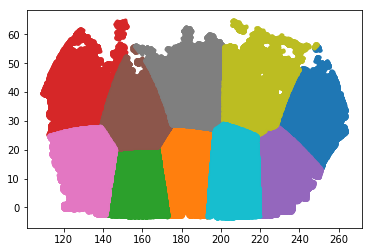

In [661]:
fig, ax = plt.subplots()
for i in range(10):
    mask = index_1st == i
    ra = cmass_ngc['RA'][mask]
    dec = cmass_ngc['DEC'][mask]
    ax.plot(ra, dec, '.')

In [995]:
jk_index = np.arange(5+1)

In [998]:
np.delete(jk_index, 2)

array([0, 1, 3, 4, 5])

In [1166]:
def combine_jk_npairs(root = './', suffix = ['', ''], kind = ['dd', 'dr', 'rr'], njack = 5 ):

    from scipy.special import eval_legendre

    jk_full_index = np.arange(njack+1)
    
    for jkinx in range(njack+1):
        jk_index = np.delete(jk_full_index, jkinx)

        datalist_dd = []
        datalist_dr = []
        datalist_rr = []
    
        for s in suffix:
            _root = root + s+'/'
            for i in jk_index:
                for j in jk_index:
                    dd_picklename = _root+'djk{}djk{}2ptdmu.dat'.format(i,j)
                    dr_picklename = _root+'djk{}rjk{}2ptdmu.dat'.format(i,j)
                    rr_picklename = _root+'rjk{}rjk{}2ptdmu.dat'.format(i,j)
                    #print dd_picklename
                    
                    #print '----------------'
                    if os.path.exists(dd_picklename):
                        #print dd_picklename, i, j
                        datalist_dd.append(np.genfromtxt(dd_picklename))
                        if i != j : 
                            datalist_dd.append(np.genfromtxt(dd_picklename))
                        #    print dd_picklename, j, i
                        else : pass

                    if os.path.exists(dr_picklename):
                        datalist_dr.append(np.genfromtxt(dr_picklename))

                    if os.path.exists(rr_picklename):
                        #print rr_picklename, i, j
                        
                        datalist_rr.append(np.genfromtxt(rr_picklename))
                        if i != j : 
                            datalist_rr.append(np.genfromtxt(rr_picklename))
                            #print dd_picklename, i, j
                        else : pass

                    else : pass 

                    
        if jkinx == njack : jkinx = 'full'
        if 'dd' in kind : 
            #datalist_dd = [d*1./d[0] for d in datalist_dd]
            datalist_dd = np.sum(datalist_dd, axis = 0)
            dd_combine_filename = _root+'dd_JK{}_combine_2ptdmu.dat'.format(jkinx)
            np.savetxt(dd_combine_filename, datalist_dd )
            print 'data save to ',dd_combine_filename

        if 'dr' in kind : 
            #datalist_dr = [d*1./d[0] for d in datalist_dr]
            datalist_dr = np.sum(datalist_dr, axis = 0)
            dr_combine_filename = _root+'dr_JK{}_combine_2ptdmu.dat'.format(jkinx)
            np.savetxt(dr_combine_filename, datalist_dr )
            print 'data save to ',dr_combine_filename

        if 'rr' in kind :
            #datalist_rr = [d*1./d[0] for d in datalist_rr]
            datalist_rr = np.sum(datalist_rr, axis = 0)
            rr_combine_filename = _root+'rr_JK{}_combine_2ptdmu.dat'.format(jkinx)
            np.savetxt(rr_combine_filename, datalist_rr )
            print 'data save to ',rr_combine_filename


In [1167]:

def binning_smu( Ncounts, sbin, mubin ):

    sbin_orig, sstep = np.linspace(0,250, 251, retstep =True)
    s = sbin_orig[:-1] + sstep/2.
    mubin_orig, mus = np.linspace(0,1,101, retstep=True)
    mu = mubin_orig[:-1]+mus/2.
    
    #npairs = Ncounts.reshape((sbin_orig.size-1, mubin_orig.size-1))
    npairs = Ncounts
    
    new_npairs = np.zeros((sbin.size-1, mubin.size-1))
    #wsqr = np.zeros((sbin.size-1, mubin.size-1))
    
    for i in range(s.size-1):
        for j in range(mu.size-1):
            ind_s = np.digitize( s[i], sbin )
            ind_mu = np.digitize( mu[j], mubin )
            if ind_s == sbin.size: pass
            elif ind_mu == mubin.size: pass
            else : 
                new_npairs[ind_s-1, ind_mu-1] += npairs[i*mu.size+j]
                #print s[i], mu[j], ind_s, ind_mu, new_npairs[ind_s-1, ind_mu-1]
    return new_npairs

def _cf_smu(DD_counts, DR_counts, RR_counts, sbin, mubin):
    
    DD = binning_smu( DD_counts, sbin, mubin )
    DR = binning_smu( DR_counts, sbin, mubin )
    RR = binning_smu( RR_counts, sbin, mubin )
    
    wd = np.sqrt(np.sum(DD))
    wdr = np.sqrt(np.sum(DR))
    wr = np.sqrt(np.sum(RR))
    norm_DD = DD # *1./wd**2
    norm_DR = DR # *1./(wd*wr)
    norm_RR = RR # *1./wr**2
    
    zeromask = norm_RR == 0
    norm_RR[zeromask] = 0.
    xi_smu = (norm_DD - 2*norm_DR + norm_RR) *1./norm_RR
    
    xi_smu[zeromask] = 0
    return xi_smu

In [1177]:
def _xi_from_jkdat(root = './', suffix = '', njack = 5):
    
    from scipy.special import eval_legendre
     
    smin = 40
    smax = 180
    snbin = 29

    sbin, step = np.linspace(smin, smax, snbin, retstep=True)

    sbin_center = sbin[:-1] + step/2.
    mubin, mus = np.linspace(0.0, 1.0, 101, retstep = True)
    mucenter = mubin[:-1]+mus/2.

    xilist = []

    s = suffix

    _root = root + s+'/'
    jkindex = list(np.arange(njack)) + ['full']
    for i in jkindex:
        dd_picklename = _root+'dd_JK{}_combine_2ptdmu.dat'.format(i)
        dr_picklename = _root+'dr_JK{}_combine_2ptdmu.dat'.format(i)
        rr_picklename = _root+'rr_JK{}_combine_2ptdmu.dat'.format(i)
        if os.path.exists(dd_picklename):
            #print dd_picklename

            #stop
            dd = np.loadtxt(dd_picklename)[1:] *1./np.loadtxt(dd_picklename)[0] 
            dr = np.loadtxt(dr_picklename)[1:] *1./np.loadtxt(dr_picklename)[0]
            rr = np.loadtxt(rr_picklename)[1:] *1./np.loadtxt(rr_picklename)[0]
            print i, np.loadtxt(dd_picklename)[0]
            
            if i == 'full' : 
                fig, ax = plt.subplots()
                ax.plot(np.arange(250), np.sum(dd.reshape(250,100), axis=1))
                ax.plot(np.arange(250), np.sum(dr.reshape(250,100), axis=1))
                ax.plot(np.arange(250), np.sum(rr.reshape(250,100), axis=1), '--', label = 'RR')
                ax.legend()
            
            
            xi_smu = _cf_smu( dd, dr, rr, sbin, mubin)                

            legendre0 = np.array([eval_legendre(0,m) for m in mucenter]).ravel() 
            #legendre2 = np.array([scipy.special.eval_legendre(2,m) for m in mucenter]).ravel() 

            xi_monopole = np.sum(xi_smu * legendre0.T, axis = 1)/mucenter.size
            #xi_quadrupole = 5*np.sum(xi_smu * legendre2.T, axis = 1)/mucenter.size
           
            if i == 'full' : xi_full = xi_monopole
            else : xilist.append(xi_monopole)

        else : break    

    
    #njack = len(xilist)-1
    
    #xi_data = np.column_stack((xilist))
    #np.savetxt(root+'/xi_jk.txt', xi_data )
    
    #xi_mean = np.mean(xilist, axis = 0)
    norm = 1. * (njack-1)/njack

    xi_cov = 0
    for k in range(njack):
        #print k 
        xi_cov +=  (xilist[k] - xi_full)**2
    xijkerr = np.sqrt(norm * xi_cov)
    
    DAT = np.column_stack((sbin_center, xi_full, xijkerr ))
    txtname = _root+'cfz_multipole'
    txtname += '_'+s

    np.savetxt(txtname+'.txt', DAT)
    print 'data save to ', txtname+'.txt'

0 39762562857.937195


/n/home00/lee.5922/.local/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in divide


1 40050303007.67734
2 39873287588.13683
3 40734669590.23969
4 39799637839.987465
full 36001190164.89597
data save to  data_txt/pair_counting/cmass_ngc_highM/cfz_multipole_cmass_ngc_highM.txt


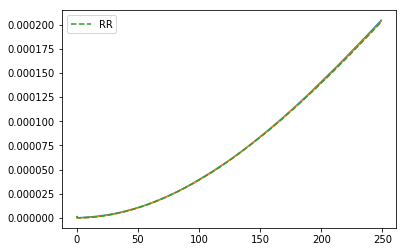

In [1178]:
#combine_jk_npairs(root = 'data_txt/pair_counting/', suffix = ['cmass_ngc_rand10'], njack = 10 )
_xi_from_jkdat(root = 'data_txt/pair_counting/', suffix = 'cmass_ngc_highM', njack = 5)

In [961]:
DD = np.genfromtxt('data_txt/pair_counting/cmass_sgc_rand100/dd_combine_2ptdmu.dat')
DR = np.genfromtxt('data_txt/pair_counting/cmass_sgc_rand100/dr_combine_2ptdmu.dat')
RR = np.genfromtxt('data_txt/pair_counting/cmass_sgc_rand100/rr_combine_2ptdmu.dat')
#DD_norm = DD.reshape(250, 100)
#DR_norm = DR.reshape(250, 100)
#RR_norm = RR.reshape(250, 100)

DD_norm =  (DD[1:] * 1./DD[0]).reshape(250, 100)
DR_norm = (DR[1:] * 1./DR[0]).reshape(250, 100)
RR_norm = (RR[1:] * 1./RR[0]).reshape(250, 100)

In [943]:
#wr = np.sqrt(np.sum(RR_norm))
#wd = np.sqrt(np.sum(DD_norm))
#wdr = np.sqrt(np.sum(DR_norm))
#DD_norm =  DD_norm * 1./wd**2
#DR_norm = DR_norm * 1./wdr**2
#RR_norm = RR_norm *1./wr**2

In [962]:
DD_s = np.sum(DD_norm, axis = 1)
DR_s = np.sum(DR_norm, axis = 1) 
RR_s = np.sum(RR_norm, axis = 1) 

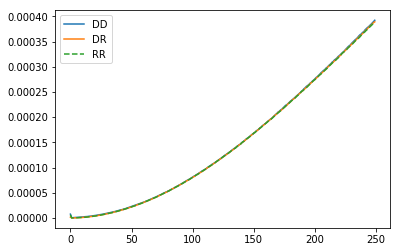

In [963]:
fig, ax = plt.subplots()
ax.plot(np.arange(DD_s.size), DD_s, label= 'DD')
ax.plot(np.arange(DD_s.size), DR_s, label = 'DR')
ax.plot(np.arange(DD_s.size), RR_s, '--',label = 'RR')
ax.legend()

(40, 180)

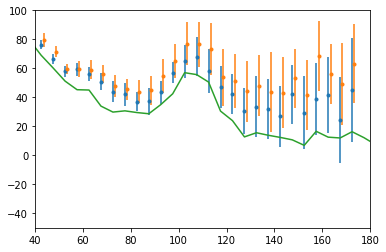

In [1215]:

theory_rr, theory_corr = np.genfromtxt('data_txt/Ashley_cmass/xi0gcmassNdr12v4_mz0.43xz0.7fcos65st0.dat', unpack=True)
#theory_corr2 = np.genfromtxt('../../bandpower/SNR/data_txt/datav/mcmc_cmass_zcut_xionly_b_monopole.datavector')[1500:1500+28]

fig, ax = plt.subplots()
#rr, rs = np.linspace(40, 180, 29, retstep=True)
#rcenter = rr[:-1] + rs/2.
rcenter, xi, xierr = np.loadtxt('data_txt/pair_counting/./cmass_ngc_rand10/cfz_multipole_cmass_ngc_rand10.txt', unpack=True)
ax.errorbar(rcenter, rcenter**2* xi, yerr = rcenter**2*xierr, fmt='.')

rcenter, xi, xierr = np.loadtxt('data_txt/pair_counting/./cmass_ngc_highM_rand10/cfz_multipole_cmass_ngc_highM_rand10.txt', unpack=True)
ax.errorbar(rcenter+1, rcenter**2* xi, yerr = rcenter**2*xierr, fmt='.')

#rcenter, xi, xierr = np.loadtxt('data_txt/pair_counting/./cmass_ngc_highM_rand10/cfz_multipole_cmass_ngc_highM_rand10.txt', unpack=True)
#ax.errorbar(rcenter+1, rcenter**2* xi, yerr = rcenter**2*xierr, fmt='.')
ax.plot(theory_rr, theory_rr**2*theory_corr)
ax.set_ylim(-50, 100)
ax.set_xlim(40, 180)
#ax.set_ylim(-50, 100)

In [1275]:
def chisqr_brel(brel, D, D2, covinv):
    brel = brel**2
    Ibanez_covinv = covinv
    chi2 = np.dot( np.dot( (D - brel*D2), Ibanez_covinv ), (D - brel*D2).T )
    return chi2*1./D.size


rcenter, xi, xierr = np.loadtxt('data_txt/pair_counting/./cmass_ngc_rand10/cfz_multipole_cmass_ngc_rand10.txt', unpack=True)
rcenter, xi_high, xierr = np.loadtxt('data_txt/pair_counting/./cmass_ngc_highM_rand10/cfz_multipole_cmass_ngc_highM_rand10.txt', unpack=True)

ibanez_cov = np.genfromtxt('../../bandpower/SNR/data_txt/cov/Pellejero-Ibanez/Pellejero-Ibanez_2016_CMASSDR12_covariance_matrix.dat') 
ibanez_inv = np.linalg.inv(ibanez_cov[:28,:28])


brelbin = np.linspace(0.9,1.1, 1000)
chilist = np.array([ chisqr_brel(rel, xi, xi_high, ibanez_inv) for rel in brelbin ])

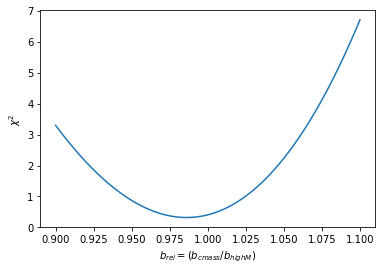

In [1276]:
fig, ax = plt.subplots()
ax.plot(brelbin, chilist)
ax.set_xlabel(r'$b_{rel} = (b_{cmass}/b_{highM})$')
ax.set_ylabel(r'$\chi^2$')

In [1278]:
argmin = chilist.argmin()
brel_bestfit = brelbin[argmin]
print brel_bestfit, chilist.min()

0.9860860860860862 0.32021119133154713


In [1345]:
def cmass_ngc_area():
    boss_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/healpix_boss_footprint_DR11v1_NGC_1024.fits')
    Npix = boss_hpind.size
    Apix = hp.nside2pixarea(nside = 1024, degrees = True)
    Boss_Area = Npix * Apix
    return Boss_Area

def dmass_spt_area():
    GoldMask = callingEliGoldMask()
    GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
    #GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

    Apix = hp.nside2pixarea( 4096, degrees = True)
    Npix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
    Area = Npix * Apix
    return Area


#####################################################
dmass_spt = esutil.io.read('/n/des/lee.5922/data/dmass_cat/dmass_spt_30.fits')
A_cmass = cmass_ngc_area()
A_dmass = dmass_spt_area()
N_cmass = cmass_ngc.size
N_dmass = dmass_spt.size
n_cmass = N_cmass * 1./A_cmass
n_dmass = N_dmass * 1./A_dmass
b_cmass = 2.0
b_dmass = b_cmass * 1./brel_bestfit

dN = N_cmass - cmass_highM.size
db_dn = A_cmass * (b_cmass - b_dmass) * 1./dN

b_difference = db_dn * (n_cmass - n_dmass)
print b_difference

fracdiff = b_difference *1./b_cmass * 100
print 'db_dn', db_dn
print 'n_cmass - n_dmass', n_cmass - 1.*n_dmass
print 'b_diff', b_difference
print fracdiff , '%'

0.006445028550512624
db_dn -0.0023753555199997165
n_cmass - n_dmass -2.713290072263959
b_diff 0.006445028550512624
0.32225142752563124 %
